In [1]:
import pandas as pd
from sqlalchemy import create_engine
import json

# DB 접속 정보 로드
with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

In [3]:
uv_dataset = pd.read_sql("SELECT * FROM uv_dataset", con=engine)

In [4]:
import pandas as pd

# 1. 전체 날짜 생성 (2015.01.01 ~ 2024.12.31)
full_dates = pd.date_range(start="2015-01-01", end="2024-12-31")

# 2. uv_dataset의 datetime 컬럼을 datetime 형식으로 변환 (혹시 몰라서)
uv_dataset['datetime'] = pd.to_datetime(uv_dataset['datetime'])

# 3. 존재하는 날짜들만 추출
existing_dates = pd.to_datetime(uv_dataset['datetime'].unique())

# 4. 누락된 날짜 찾기 (차집합)
missing_dates = full_dates.difference(existing_dates)

# 5. 출력
print(f"누락된 날짜 개수: {len(missing_dates)}")
print("누락된 날짜 예시:")
print(missing_dates[:10])  # 상위 10개만 보기

# 필요시 DataFrame으로 저장
missing_df = pd.DataFrame(missing_dates, columns=["missing_date"])

누락된 날짜 개수: 60
누락된 날짜 예시:
DatetimeIndex(['2015-12-02', '2015-12-03', '2015-12-04', '2015-12-05',
               '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09',
               '2015-12-10', '2015-12-11'],
              dtype='datetime64[ns]', freq=None)


In [5]:
import pandas as pd
import numpy as np

# 1. 전체 날짜 생성
full_dates = pd.date_range(start="2015-01-01", end="2024-12-31")
full_dates_df = pd.DataFrame(full_dates, columns=['datetime'])

# 2. datetime 형식 통일
uv_dataset['datetime'] = pd.to_datetime(uv_dataset['datetime'])

# 3. 누락된 날짜 찾기
missing_dates = full_dates_df[~full_dates_df['datetime'].isin(uv_dataset['datetime'])].copy()
print(f"누락된 날짜 수: {len(missing_dates)}")

# 4. 연도별 평균값 계산 (datetime → year 추가)
uv_dataset['year'] = uv_dataset['datetime'].dt.year
grouped_means = uv_dataset.groupby('year').mean(numeric_only=True).round(2)

# 5. 누락된 날짜에 해당 연도 붙이기
missing_dates['year'] = missing_dates['datetime'].dt.year

# 6. 연도별 평균값을 누락된 날짜에 매핑
#    → year 기준으로 left join
filled_missing = missing_dates.merge(grouped_means, how='left', left_on='year', right_index=True)

# 7. 누락된 row에 region 채우기 (서울시라고 가정)
filled_missing['region'] = '서울시'

# 8. 컬럼 순서 맞추기 (원본 df 기준)
filled_missing = filled_missing[uv_dataset.columns]

# 9. year 컬럼 제거 (정리용, 혹시나 있으면)
uv_dataset.drop(columns='year', inplace=True, errors='ignore')

# 10. 원본 df와 합치기
filled_df = pd.concat([uv_dataset, filled_missing], ignore_index=True)
filled_df = filled_df.sort_values('datetime').reset_index(drop=True)

# 확인
print("최종 행 개수:", len(filled_df))  # 3652일치면 3652개 나와야 함

누락된 날짜 수: 60
최종 행 개수: 3653


In [6]:
filled_df

,datetime,region,no2,co,so2,o3,pm10,pm25,temperature,wind_direction,wind_speed,precipitation,humidity,uv_max,year
0,2015-01-01,서울시,0.026,0.8,0.008,0.032,168.0,42.0,-3.8,358.9,8.3,0.0,71.0,4.7,NaN
1,2015-01-02,서울시,0.048,1.0,0.009,0.034,57.0,27.0,-0.9,359.6,7.0,0.0,82.0,4.7,NaN
2,2015-01-03,서울시,0.079,1.6,0.012,0.020,76.0,50.0,3.0,359.8,3.7,0.0,91.0,4.7,NaN
3,2015-01-04,서울시,0.104,2.7,0.011,0.027,97.0,53.0,8.2,359.3,4.2,0.0,100.0,4.7,NaN
4,2015-01-05,서울시,0.106,2.6,0.018,0.028,133.0,77.0,9.9,359.3,5.0,0.0,100.0,4.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2024-12-27,서울시,0.046,0.8,0.007,0.043,45.0,24.0,2.7,357.4,7.0,0.0,80.0,3.3,NaN
3649,2024-12-28,서울시,0.037,0.8,0.008,0.041,47.0,23.0,1.2,358.6,6.7,0.0,72.0,3.5,NaN
3650,2024-12-29,서울시,0.054,1.1,0.009,0.037,41.0,30.0,6.6,359.7,3.4,0.0,87.0,3.5,NaN
3651,2024-12-30,서울시,0.058,1.3,0.008,0.052,95.0,59.0,10.3,359.5,6.5,0.0,91.0,3.0,NaN


In [7]:
filled_df['datetime'] = pd.to_datetime(filled_df['datetime'])
filled_df = filled_df.sort_values('datetime').reset_index(drop=True)
filled_df.set_index('datetime', inplace=True)

In [9]:
target = filled_df[['uv_max']]  # 예측 대상

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# seoul_uv 는 datetime을 인덱스로 가진 상태여야 함
data = filled_df['uv_max'].fillna(method='ffill').values.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

print(f"데이터 형태: {data_scaled.shape}")

데이터 형태: (3653, 1)


C:\Users\user\AppData\Local\Temp\ipykernel_17768\1593205140.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = filled_df['uv_max'].fillna(method='ffill').values.reshape(-1, 1)


In [11]:
# 입력과 출력 길이 설정
INPUT_LEN = 30  # 과거 30일
OUTPUT_LEN = 10  # 향후 10일 예측

X, y = [], []

for i in range(len(data_scaled) - INPUT_LEN - OUTPUT_LEN + 1):
    X.append(data_scaled[i : i + INPUT_LEN])
    y.append(data_scaled[i + INPUT_LEN : i + INPUT_LEN + OUTPUT_LEN])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (3614, 30, 1), y shape: (3614, 10, 1)


In [12]:
# 맨 마지막 샘플 하나만 테스트용으로 사용
X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1:]
y_test = y[-1:]

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape :", X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape: (3613, 30, 1)
y_train.shape: (3613, 10, 1)
X_test.shape : (1, 30, 1)
y_test.shape : (1, 10, 1)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# 모델 정의
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(30, 1)),
    Dense(32, activation='relu'),
    Dense(10)  # OUTPUT_LEN = 10
])

# 컴파일
model.compile(optimizer='adam', loss='mse')

# 학습
history = model.fit(X_train, y_train.reshape(-1, 10),  # reshape해서 Dense와 연결
                    epochs=100,
                    batch_size=16,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/100


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0450 - val_loss: 0.0203
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0139 - val_loss: 0.0204
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0144 - val_loss: 0.0219
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0140 - val_loss: 0.0203
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0132 - val_loss: 0.0207
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0137 - val_loss: 0.0206
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0135 - val_loss: 0.0206
Epoch 8/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0142 - val_loss: 0.0206
Epoch 9/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0133 - val_loss: 0.0206
Epoch 10/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0141 - val_loss: 0.0204
Epoch 11/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0140 - val_loss: 0.0211
Epoch 12/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste

In [14]:
# 예측
lstm_pred = model.predict(X_test)

# 정규화 해제 (역정규화)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

# RMSE 계산
from sklearn.metrics import mean_squared_error
from math import sqrt

lstm_rmse = sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
print(f"LSTM RMSE: {lstm_rmse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
LSTM RMSE: 0.72


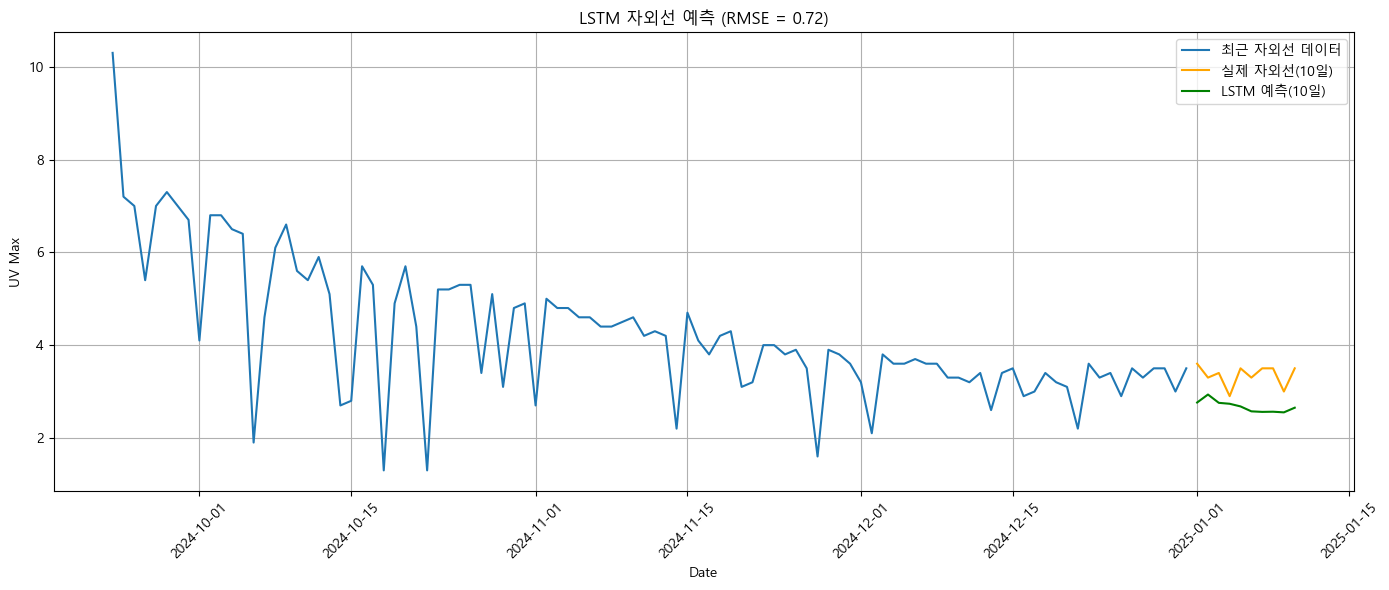

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False


# 마지막 날짜로부터 10일 생성
forecast_dates = pd.date_range(start=filled_df.index[-1] + pd.Timedelta(days=1), periods=10)

# 최근 데이터 시각화를 위해 마지막 100일치 원래값
recent_data_unscaled = scaler.inverse_transform(data_scaled[-100:]).flatten()
recent_dates = filled_df.index[-100:]

plt.figure(figsize=(14, 6))
plt.plot(recent_dates, recent_data_unscaled, label='최근 자외선 데이터')
plt.plot(forecast_dates, y_test_unscaled, label='실제 자외선(10일)', color='orange')
plt.plot(forecast_dates, y_pred_unscaled, label='LSTM 예측(10일)', color='green')

plt.title(f"LSTM 자외선 예측 (RMSE = {lstm_rmse:.2f})")
plt.xlabel("Date")
plt.ylabel("UV Max")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()